In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

import warnings
warnings.filterwarnings("ignore")

# set defaults
plt.style.use('seaborn-white')   # seaborn custom plot style
plt.rc('figure', dpi=100, figsize=(7, 5))   # set default size/resolution
plt.rc('font', size=12)   # font size

# Lecture 7

### Permutation Tests

## Review: Performing Hypothesis Tests

1. Pose a (null and alternative) hypothesis related to an observation.
2. Choose a test-statistic that can answer the hypothesis
3. Choose a significance level $\alpha$ that reflects the certainty you require:
    - a value of $\alpha = 0.05 = \frac{1}{20}$ results in a 'false discovery' 1 in 20 times.
4. Generate data under the null hypothesis (via simulation).
5. If the proportion of the simulations resulting in an outcome *at least as extreme* as the observed data is less than $\alpha$ then it's unlikely to have been generated by the simulations.
    - i.e. reject the null hypothesis.

## Review: Hypothesis Testing

* Given a *single* observed sample,
* Make an assumption of how it came to be
    - This assumption is the *null hypothesis*
    - Generate data under this assumption (*probability model*)
* Simulate data under the null hypothesis (the null distribution)
* Ask "is it likely the given observation arose from this assumption?"

## Today's lecture

- So far, Hypothesis tests assess a model given a single random sample.
    - We flip a coin 400 times. Are the flips consistent with the coin being fair?
        -- We have a known distribution of the fair coin. We can sample from it. We have a theoretical probability model. 
    - Did the jury panel look like a random sample from the eligible population?
        -- Theoretical prob. model from census data.
    - Do the test scores for section #3 look like a random sample from the class's scores?
        -- WE have empirical distribution of scores. We created random sections #3 from this distribution. 
- But we often have *two* random samples we wish to compare.
    - Outcomes of patients assigned to control group and treatment group in a pharmaceutical study.
    - Number of clicks from people who saw version A of an advertisement vs. version B

## A/B Testing

* Given two observed populations, are they fundamental different, or could they have been generated by the same process?
* Decide whether two *fixed* random samples come from the same distribution.
    -- You do not know what generated them!


# Example 1: Birth Weight and Smoking

## Smoking and birth weight

- Is there a significant difference in the weight of babies born to mothers who smoke, vs. non-smokers?
- Two groups:
    - babies whose mothers smoke during pregnancy
    - babies whose mothers do not smoke during pregnancy
- Outcome to measure:
    - babies birth weights. 

In [2]:
# Kaiser dataset, 70s 
baby_fp = os.path.join('data', 'baby.csv')
baby = pd.read_csv(baby_fp)
baby.head()

,Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
0,120,284,27,62,100,False
1,113,282,33,64,135,False
2,128,279,28,64,115,True
3,108,282,23,67,125,True
4,136,286,25,62,93,False


In [3]:
#: we only need "Birth Weight" and "Maternal Smoker"
smoking_and_birthweight = baby[['Maternal Smoker', 'Birth Weight']]
smoking_and_birthweight.head()

,Maternal Smoker,Birth Weight
0,False,120
1,False,113
2,True,128
3,True,108
4,False,136


## First, some exploratory analysis
* How many are in each group?
* What is the average weight within each group?

In [4]:
# how many are in each group?
smoking_and_birthweight.groupby('Maternal Smoker').count()

,Birth Weight
Maternal Smoker,
False,715
True,459


In [5]:
# what is the average weight (in ounces) within each group?
smoking_and_birthweight.groupby('Maternal Smoker').mean()

# ^^ 10 ounces ~ 283.495 grams
# Avearge weight overall: 7.5 pounds ~ 3.4kg

,Birth Weight
Maternal Smoker,
False,123.085315
True,113.819172


## Visualizing the distribution of each group
- Does the difference we see reflect a real difference in the population?
- Or is it just due to random chance?

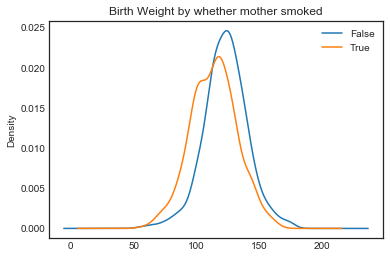

In [7]:
# look at the actual distributions

title='Birth Weight by whether mother smoked'

(
    smoking_and_birthweight
    .groupby('Maternal Smoker')['Birth Weight']
    .plot(kind='kde', legend=True, subplots=False, title=title)
);    

## The question:

Try a hypothesis test?
* But *both* samples are fixed beforehand?
* But what is the (null) distribution being simulated?

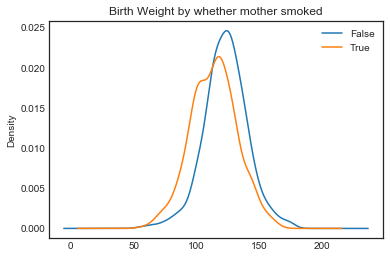

In [8]:
title='Birth Weight by whether mother smoked'
(
    smoking_and_birthweight
    .groupby('Maternal Smoker')['Birth Weight']
    .plot(kind='kde', legend=True, subplots=False, title=title)
);   

## Testing the hypothesis

- **Null hypothesis**: In the population, birth weights of smokers and non-smokers have the same distribution.
    - I.e., what we saw is due to random chance.
- **Alternative hypothesis**: In the population, babies born to smokers typically have lower birth weight.

## Alternative hypothesis: birth weights come from *different* distributions
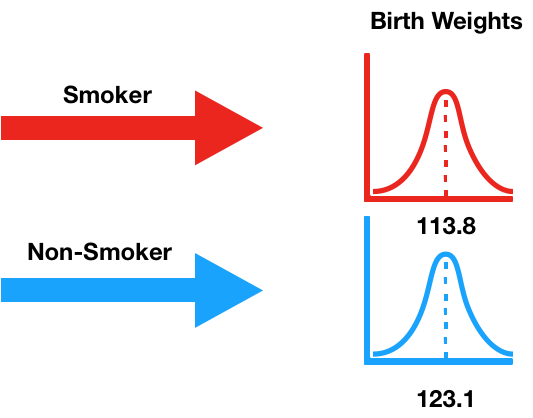

## Null hypothesis: birth weights come from the *same* distribution
- Smoker/Non-smoker labels have no relationship to birth-weight. 
- It *may have well* been assigned at random.

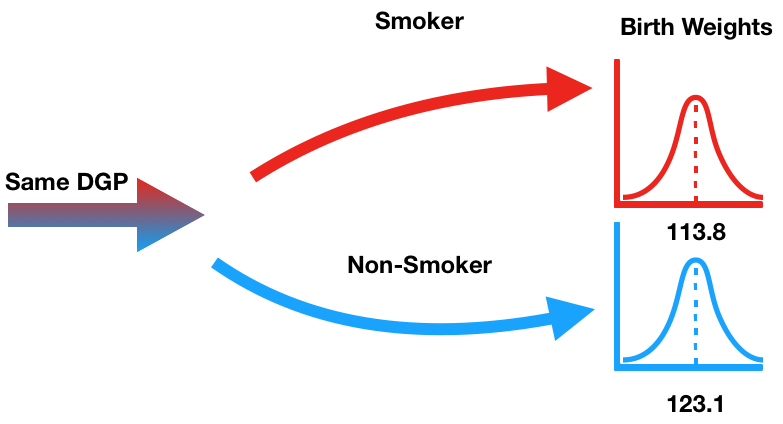

## Choosing a Test Statistic

- What is a reasonable statistic to compute in order to test the null hypothesis?
    * Should differentiate between the distributions.
    * Most simple statistic: **difference in means**

In [9]:
means_table = smoking_and_birthweight.groupby('Maternal Smoker').mean()
means_table

,Birth Weight
Maternal Smoker,
False,123.085315
True,113.819172


In [10]:
s = pd.Series([1, 2, 5, 9, 15])
s

0     1
1     2
2     5
3     9
4    15
dtype: int64

In [11]:
s = pd.Series([1, 2, 5, 9, 15])
s.diff()

0    NaN
1    1.0
2    3.0
3    4.0
4    6.0
dtype: float64

In [12]:
means_table

,Birth Weight
Maternal Smoker,
False,123.085315
True,113.819172


In [13]:
observed_difference = means_table.diff()#.iloc[-1,0]
observed_difference

,Birth Weight
Maternal Smoker,
False,NaN
True,-9.266143


In [14]:
observed_difference = means_table.diff().iloc[-1,0]
observed_difference

-9.266142572024918

## Testing through simulation

- **Statistic**: Difference between means.
- **Null hypothesis**: The two groups are sampled from the same distribution.
- Note that the null hypothesis doesn't say *what* the distribution is.
    - Different from jury panel example, fair coin example, etc.
    - We can't draw directly from the distribution!
- We have to do something a bit more clever.

## Implications of the null hypothesis

- Under the null hypothesis, both groups are sampled from the same distribution.
- If true, then the group label (`Maternal Smoker`) has no effect on the birth weight.
- We saw one assignment of group labels:

In [15]:
smoking_and_birthweight.head()

,Maternal Smoker,Birth Weight
0,False,120
1,False,113
2,True,128
3,True,108
4,False,136


- But (under the null hypothesis) we were just as likely to see *any other* assignment.

## Permutation tests

- Perhaps the difference in means we saw is due to random chance in assignment.
- **Permutation test**: Shuffle the group labels a bunch of times; how often do we see a statistic this extreme?
- Randomly permuting labels is equivalent to randomly assigning birth weights to groups (without changing group sizes)
- If we *rarely* see something this extreme, then the null hypothesis doesn't look likely.

## Permutation tests with dataframes

- We want to randomly shuffle the `Maternal Smoker` column.
- To shuffle rows, we can use `.sample(replace=False, frac=1)`.
    -- Computationally expensive
- Notice: Both rows are shuffled together (i.e., not independently)!

In [19]:
# (re)run multiple times!
smoking_and_birthweight.head().sample(replace=False, frac=1)

,Maternal Smoker,Birth Weight
4,False,136
0,False,120
3,True,108
1,False,113
2,True,128


## Discussion Question

In the birthweight example, we want to shuffle only one column. For the purpose of permutation testing, 
does it matter which column we shuffle -- the `Maternal Smoker` column or the `Birth Weight` column?

- A) Yes
- B) No

## Shuffling the groups

In [20]:
smoking_and_birthweight.head()

,Maternal Smoker,Birth Weight
0,False,120
1,False,113
2,True,128
3,True,108
4,False,136


In [21]:
#: it doesn't matter which column we shuffle! Here, we'll shuffle weights
shuffled_weights = (
    smoking_and_birthweight['Birth Weight']
    .sample(replace=False, frac=1)
    .reset_index(drop=True)
)

original_and_shuffled = (
    smoking_and_birthweight
    .assign(**{'Shuffled Birth Weight': shuffled_weights})
)

original_and_shuffled.head(10)

,Maternal Smoker,Birth Weight,Shuffled Birth Weight
0,False,120,143
1,False,113,114
2,True,128,146
3,True,108,144
4,False,136,118
5,False,138,127
6,False,132,147
7,False,120,96
8,True,143,125
9,False,140,78


In [22]:
#: it doesn't matter which column we shuffle! Here, we'll shuffle weights
shuffled_weights = (
    smoking_and_birthweight['Birth Weight']
    .sample(replace=False, frac=1)
    #.reset_index(drop=True)
)

shuffled_weights

549     147
464     112
725      96
529     133
1049    131
960     111
578     120
31      130
129     122
176     136
1105    106
706     112
514     129
1163    113
515     124
977     160
1038    123
1011    108
993     102
258     129
594     176
556     118
754     124
171     137
1167    127
716      91
919     120
541     111
293     117
358     126
       ... 
1068    126
1161    115
503     115
169     124
441     109
908     135
409     129
455     130
264     110
922      55
768     137
886      99
1124    126
82      138
99      126
450     104
15       92
369     145
70      120
75      120
1080    114
230      99
442     117
737     126
643     117
462     101
537      91
794     116
988     120
46      145
Name: Birth Weight, Length: 1174, dtype: int64

In [ ]:
# side note: 
# https://pythontips.com/2013/08/04/args-and-kwargs-in-python-explained/
    
#assign 

#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.assign.html

In [23]:
shuffled_weights = (
    smoking_and_birthweight['Birth Weight']
    .sample(replace=False, frac=1)
    .reset_index(drop=True)
)

original_and_shuffled = (
    smoking_and_birthweight
    .assign(**{'Shuffled Birth Weight': shuffled_weights})
)



original_and_shuffled.head(10)
# what will happen if I do not reset index?
# assign matches the indices!
# un-shuffled :(

,Maternal Smoker,Birth Weight,Shuffled Birth Weight
0,False,120,140
1,False,113,164
2,True,128,132
3,True,108,127
4,False,136,134
5,False,138,118
6,False,132,65
7,False,120,102
8,True,143,99
9,False,140,115


## How close are the means of the shuffled groups?

In [24]:
#: shuffling the weights makes it easier to do this...
original_and_shuffled.groupby('Maternal Smoker').mean()

,Birth Weight,Shuffled Birth Weight
Maternal Smoker,,
False,123.085315,119.897902
True,113.819172,118.784314


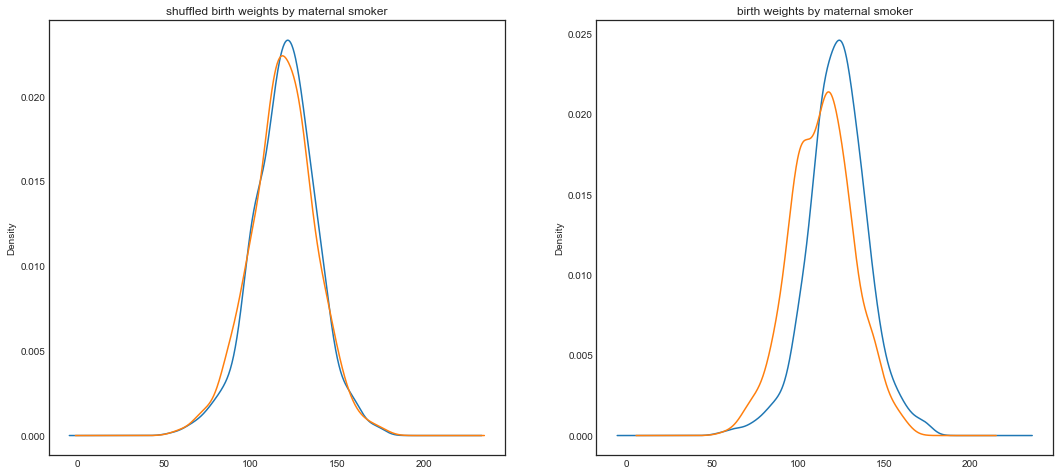

In [25]:
#: the distribution of the shuffled groups

fig, axes = plt.subplots(1,2, figsize=(18,8))

title = 'shuffled birth weights by maternal smoker'
original_and_shuffled.groupby('Maternal Smoker')['Shuffled Birth Weight'].plot(kind='kde', title=title, ax=axes[0])

title = 'birth weights by maternal smoker'
original_and_shuffled.groupby('Maternal Smoker')['Birth Weight'].plot(kind='kde', title=title, ax=axes[1]);

## Simulation

- This was just one random shuffle.
- How likely is it that a random shuffle results in a 9+ ounce difference in means?
- We have to repeat the shuffling a bunch of times. On each iteration:
    1. Shuffle the weights.
    2. Put them in a table.
    3. Compute difference in group means.

In [26]:
n_repetitions = 500

differences = []
for _ in range(n_repetitions):
    
    # shuffle the weights
    shuffled_weights = (
        smoking_and_birthweight['Birth Weight']
        .sample(replace=False, frac=1)
        .reset_index(drop=True)
    )
    
    # put them in a table
    shuffled = (
        smoking_and_birthweight
        .assign(**{'Shuffled Birth Weight': shuffled_weights})
    )
    
    # compute the group differences (test statistic!)
    group_means = (
        shuffled
        .groupby('Maternal Smoker')
        .mean()
        .loc[:, 'Shuffled Birth Weight']
    )
    difference = group_means.diff().iloc[-1]
    
    # add it to the list of results
    differences.append(difference)

In [27]:
observed_difference = (
    smoking_and_birthweight
    .groupby('Maternal Smoker')['Birth Weight']
    .mean()
    .diff()
    .iloc[-1]
)

## Conclusion of the test

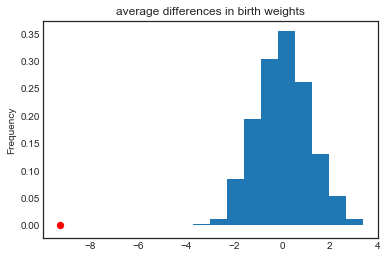

In [28]:
title = 'average differences in birth weights'
pd.Series(differences).plot(kind='hist', density=True, title=title)
plt.scatter(observed_difference, 0, color='red', s=40);

- Under the null hypothesis, we rarely see differences as large as this.
- Therefore, we reject the null hypothesis: the two groups do not come from the same distribution.

## Caution!

- We **cannot** conclude that smoking *causes* lower birth weight!
- This was an observational study; there may be confounding factors.
    - Maybe smokers are more likely to drink caffeine, and caffeine causes lower birth weight.
- But it suggests that it is worth studying with a randomized controlled trial.

## A slightly different example

- Is there a difference in birthweight between babies born to:
    - Group A: Mothers over 25
    - Group B: Mothers 25 or under

In [29]:
over_25 = baby['Maternal Age'] > 25
age_and_birthweight = (
    baby[['Birth Weight']]
    .assign(**{'Over 25': over_25})
)

age_and_birthweight.head()

,Birth Weight,Over 25
0,120,True
1,113,True
2,128,True
3,108,False
4,136,False


In [30]:
#: the group means
group_means = age_and_birthweight.groupby('Over 25').mean()
group_means

,Birth Weight
Over 25,
False,118.495183
True,120.229008


In [31]:
#: the difference between them
observed_difference = group_means['Birth Weight'].diff().iloc[-1]
observed_difference

1.7338245892717907

## The permutation test

- **Null hypothesis**: Birth weights for both groups come from the same distribution.
- **Alternative hypothesis**: No, mothers below 25 have heavier babies.
- We run a permutation test with the difference in means as the statistic.

## Simulation

In [32]:
n_repetitions = 500

differences = []
for _ in range(n_repetitions):
    
    # shuffle the weights
    shuffled_weights = (
        age_and_birthweight['Birth Weight']
        .sample(replace=False, frac=1)
        .reset_index(drop=True)
    )
    
    # put them in a table
    shuffled = (
        age_and_birthweight
        .assign(**{'Shuffled Birth Weight': shuffled_weights})
    )
    
    # compute the group differences
    group_means = (
        shuffled
        .groupby('Over 25')
        .mean()
        .loc[:, 'Shuffled Birth Weight']
    )
    difference = group_means.diff().iloc[-1]
    
    # add it to the list of results
    differences.append(difference)

## Conclusion of the test

- Do we reject the null hypothesis?
- What can we compute to tell us the degree of uncertainty here?

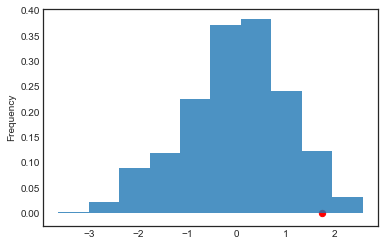

In [33]:
#: visualize
pd.Series(differences).plot(kind='hist', density=True, alpha=0.8)
plt.scatter(observed_difference, 0, color='red', s=40);

## The p-value

- The probability of seeing a difference of means at least as extreme as the observed, under the null hypothesis.

In [38]:
np.count_nonzero(differences >= observed_difference) / n_repetitions
#using p value to determine whether reject or not 

0.034

### Permutation Test Summary
* A permutation test *is a hypothesis test*
    - Null hypothesis states "two observations come from same distribution".
    - Simulate null hypothesis using *permutations*.
* Don't have to know *what* the distributions are!
* When test-statistic is is difference-in-means <=> two sample t-test
* Permutation tests are more generally applicable.

## Example: Married Couples vs Unmarried Partners

* Study conducted in 2010 by the [National Center for Family and Marriage Research](https://www.bgsu.edu/ncfmr.html).
* Data: National random sample of over 1,000 heterosexual couples who were either married or living together but unmarried.
* Each row corresponds to one person.

In [35]:
couples_fp = os.path.join('data', 'married_couples.csv')
couples = pd.read_csv(couples_fp)

In [36]:
len(couples)

2068

In [37]:
couples = couples[['mar_status', 'empl_status', 'gender', 'age']]
couples.head()

,mar_status,empl_status,gender,age
0,1,1,1,51
1,1,1,2,53
2,1,1,1,57
3,1,1,2,57
4,1,1,1,60


### Cleaning the dataset

* `mar_status`: 1=married, 2=unmarried
* `empl_status`: enumerated in the list below
* `gender`: 1=male, 2=female
* `age`: Person's age in years

In [39]:
couples.head()

,mar_status,empl_status,gender,age
0,1,1,1,51
1,1,1,2,53
2,1,1,1,57
3,1,1,2,57
4,1,1,1,60


In [40]:
empl = [
    'Working as paid employee',
    'Working, self-employed',
    'Not working - on a temporary layoff from a job',
    'Not working - looking for work',
    'Not working - retired',
    'Not working - disabled',
    'Not working - other'
]

In [41]:
couples = couples.replace({
    'mar_status': {1:'married', 2:'partner'},
    'gender': {1:'M', 2:'F'},
    'empl_status': {(k + 1): empl[k] for k in range(len(empl))}
})

In [42]:
couples

,mar_status,empl_status,gender,age
0,married,Working as paid employee,M,51
1,married,Working as paid employee,F,53
2,married,Working as paid employee,M,57
3,married,Working as paid employee,F,57
4,married,Working as paid employee,M,60
5,married,Working as paid employee,F,57
6,married,"Working, self-employed",M,62
7,married,Working as paid employee,F,59
8,married,Not working - other,M,53
9,married,Not working - retired,F,61


### Understanding the `couples` dataset

* Who is in our dataset? mostly young? mostly married? mostly employed?
* What are the distributions of values in each column?
* What are the ages conditional on other attributes?
    -- Bivariate statistics

In [43]:
# Are there any other values unaccounted for? 
# What are distributions of each field?

for c in couples:
    # display top 10 values
    empr = couples[c].value_counts(normalize=True).to_frame().iloc[:10]
    display(empr)

,mar_status
married,0.717602
partner,0.282398


,empl_status
Working as paid employee,0.605899
Not working - other,0.103965
"Working, self-employed",0.098646
Not working - looking for work,0.067698
Not working - disabled,0.056576
Not working - retired,0.050774
Not working - on a temporary layoff from a job,0.016441


,gender
M,0.5
F,0.5


,age
53,0.037234
55,0.036750
54,0.031431
40,0.030464
44,0.029981
30,0.028046
48,0.027563
52,0.027079
49,0.027079
43,0.026596


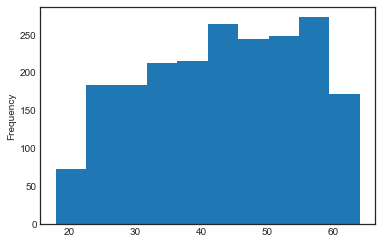

In [44]:
couples['age'].plot(kind='hist');

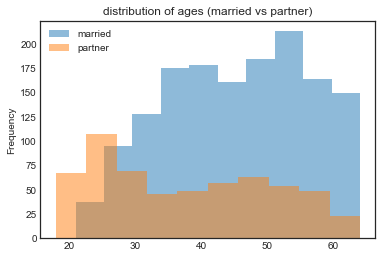

In [45]:
# which way does it skew? Why?
# counts are plotted: groups have different sizes

title = 'distribution of ages (married vs partner)'

G = couples.groupby('mar_status')

ax = G.get_group('married')['age'].rename('married').plot(kind='hist', alpha=0.5, legend=True, title=title)
G.get_group('partner')['age'].rename('partner').plot(kind='hist', alpha=0.5, ax=ax, legend=True);

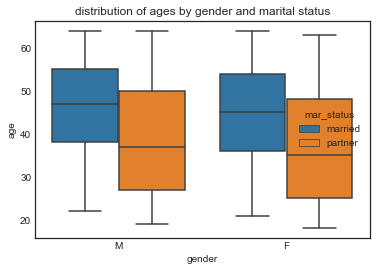

In [46]:
# break by age and gender 
# What do you observe?

ax = sns.boxplot(y='age', x='gender', data=couples, hue='mar_status')
ax.set_title('distribution of ages by gender and marital status');

### Understanding employment status in households

* Do married households more often have a stay-at-home spouse?
* Do households with partners more often have someone looking for work?
* How much does the employment status of the different households vary?

Compute the distribution of employment status *conditional on household type*.

In [47]:
# counts -- why aren't they easy to compare?

empl_cnts = couples.pivot_table(index='empl_status', columns='mar_status', aggfunc='size')
empl_cnts

mar_status,married,partner
empl_status,,
Not working - disabled,72,45
Not working - looking for work,71,69
Not working - on a temporary layoff from a job,21,13
Not working - other,182,33
Not working - retired,94,11
Working as paid employee,906,347
"Working, self-employed",138,66


In [48]:
# total counts for each
empl_cnts.sum().to_frame().T

mar_status,married,partner
0,1484,584


In [49]:
# conditional distribution
cond_distr = empl_cnts.apply(lambda x: x / x.sum())
cond_distr

mar_status,married,partner
empl_status,,
Not working - disabled,0.048518,0.077055
Not working - looking for work,0.047844,0.118151
Not working - on a temporary layoff from a job,0.014151,0.022260
Not working - other,0.122642,0.056507
Not working - retired,0.063342,0.018836
Working as paid employee,0.610512,0.594178
"Working, self-employed",0.092992,0.113014


### Differences in the distributions

* Is the distribution of employment status different for married people in the U.S. than it is for unmarried people who live with their partners?
* Is this difference just due to noise?

Perform a statistical test for this hypothesis

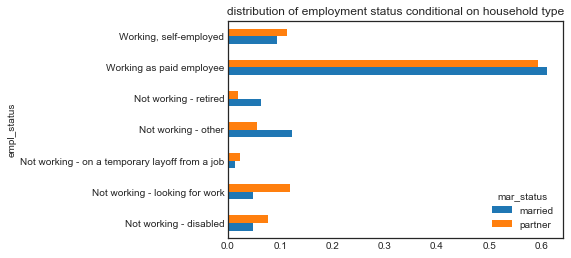

In [50]:
title='distribution of employment status conditional on household type'
cond_distr.plot(kind='barh', title=title);

### Permutation test for household composition 

* **Null hypothesis**: In the US, the distribution of employment status among those married is the same as among those unmarried who live with their partners. The difference between the two samples is due to chance.

* **Alternative hypothesis**: In the United States, the distributions of the employment status of the two groups are different.

* **Test statistic**: Total Variation Distance

Set a significance level of 0.05

In [51]:
cond_distr

mar_status,married,partner
empl_status,,
Not working - disabled,0.048518,0.077055
Not working - looking for work,0.047844,0.118151
Not working - on a temporary layoff from a job,0.014151,0.022260
Not working - other,0.122642,0.056507
Not working - retired,0.063342,0.018836
Working as paid employee,0.610512,0.594178
"Working, self-employed",0.092992,0.113014


In [52]:
# observed test statstic
cond_distr.diff(axis=1).iloc[-1].abs().sum() / 2

0.010010892441753128

In [53]:
couples.head()

,mar_status,empl_status,gender,age
0,married,Working as paid employee,M,51
1,married,Working as paid employee,F,53
2,married,Working as paid employee,M,57
3,married,Working as paid employee,F,57
4,married,Working as paid employee,M,60


In [54]:
# test statistic for permutation test
def tvd_of_groups(df):
    cnts = df.pivot_table(index='empl_status', columns='mar_status', aggfunc='size')
    distr = cnts.apply(lambda x: x / x.sum())   # normalized 
    return distr.diff(axis=1).iloc[-1].abs().sum() / 2  # TVD

In [55]:
obs = tvd_of_groups(couples)
obs

0.010010892441753128

In [56]:
couples.head()

,mar_status,empl_status,gender,age
0,married,Working as paid employee,M,51
1,married,Working as paid employee,F,53
2,married,Working as paid employee,M,57
3,married,Working as paid employee,F,57
4,married,Working as paid employee,M,60


In [57]:
s = couples['mar_status'].sample(frac=1, replace=False).reset_index(drop=True)
s

0       partner
1       married
2       married
3       married
4       married
5       married
6       married
7       married
8       married
9       married
10      married
11      married
12      married
13      married
14      married
15      married
16      partner
17      partner
18      married
19      partner
20      married
21      married
22      partner
23      married
24      married
25      married
26      partner
27      married
28      married
29      married
         ...   
2038    partner
2039    partner
2040    married
2041    married
2042    married
2043    married
2044    married
2045    married
2046    partner
2047    partner
2048    partner
2049    married
2050    married
2051    married
2052    married
2053    married
2054    partner
2055    partner
2056    partner
2057    partner
2058    married
2059    married
2060    married
2061    married
2062    married
2063    partner
2064    married
2065    partner
2066    married
2067    married
Name: mar_status, Length

In [58]:
shuffled = couples.loc[:, ['empl_status']].assign(mar_status=s)
shuffled

,empl_status,mar_status
0,Working as paid employee,partner
1,Working as paid employee,married
2,Working as paid employee,married
3,Working as paid employee,married
4,Working as paid employee,married
5,Working as paid employee,married
6,"Working, self-employed",married
7,Working as paid employee,married
8,Not working - other,married
9,Not working - retired,married


In [62]:
# TVD
tvd_of_groups(shuffled)


0.0007269320237787563

In [63]:
# simulation
# 

N = 1000
tvds = []
for _ in range(N):
    
    s = couples['mar_status'].sample(frac=1, replace=False).reset_index(drop=True)
    shuffled = couples.loc[:, ['empl_status']].assign(mar_status=s)
    
    tvds.append(tvd_of_groups(shuffled))

tvds = pd.Series(tvds)

In [61]:
pval = (tvds >= obs).sum() / N
pval

0.2

### Conclusion: Household composition

* We **cannot** reject the null hypothesis that married/unmarried households have the similar employment makeup.
* This does **not** mean we 'accept' the null hypothesis; our answer depends on our choice of statistic.

Use the plot below to check our work!

In [ ]:
tvds.plot(kind='hist', title='p-value: %f' % pval)
plt.scatter([obs], [0], s=50, color='r')

perc = np.percentile(tvds, 95) # 5% significance level
plt.axvline(x=perc, color='y');

### An alternative investigation

* Is their a significant difference in people 'Not working', but either looking for work or disabled?
    - i.e. people out-of-work not by choice
* Look at average number of "out-of-work not by choice" households in each group.
    - Then we can use difference in means between the groups.

In [ ]:
not_work_no_choice = couples.empl_status.isin(['Not working - looking for work', 'Not working - disabled'])

In [ ]:
couples['not_work_no_choice'] = not_work_no_choice.replace({True:1, False:0})
couples.head()

In [ ]:
# not categorical distr. anymore
# just 0 and 1s
obs = couples.groupby('mar_status')['not_work_no_choice'].mean().diff().iloc[-1]
obs

In [ ]:
N = 1000
means = []
for _ in range(N):
    
    s = couples['mar_status'].sample(frac=1, replace=False).reset_index(drop=True)
    shuffled = couples.loc[:, ['not_work_no_choice']].assign(mar_status=s)

    m = shuffled.groupby('mar_status')['not_work_no_choice'].mean().diff().iloc[-1]
    
    means.append(m)

means = pd.Series(means)

In [ ]:
pval = (means >= obs).sum() / N
pval

### Conclusion: Household composition; not working, not by choice

* We **can** reject the null hypothesis that married/unmarried households are similarly composed of those not working (not by choice) and otherwise.
* Why does this result differ from the TVD example?
* *Remark*: this does **not** support our explanation for what causes this difference!

Use the plot below to check our work!

In [ ]:
means.plot(kind='hist', title='p-value: %f' % pval)
plt.scatter([obs], [0], s=50, color='r')

perc = np.percentile(means, 95) # 5% significance level
plt.axvline(x=perc, color='y');

## Example: Deflategate

## Did the New England Patriots cheat?

<div class="image-txt-container">
    
<img width="50%" src="./imgs/deflate.jpg">

- On January 18, 2015, the Patriots played the Indianapolis Colts for a spot in the Super Bowl
- The Patriots won, 45 -- 7. They went on to win the Super Bowl
- After the game, it was alleged that the Patriots intentionally deflated footballs (making them easier to catch)

</div>

## Background

- Each team brings 12 footballs to the game.
- NFL rules stipulate: each ball must be inflated to between 12.5 and 13.5 pounds per square inch (psi).
- Before the game, officials found that all of the Patriot's balls were at about 12.5 psi, all of the Colts were about 13.0 psi.
- In the second quarter, Colts intercepted a Patriots ball and notified officials that it felt under-inflated.
- At halftime, two officials (Blakeman and Prioleau) each measured the pressure again.
- They ran out of time, and couldn't measure the pressure of all of the footballs.

## The measurements

In [ ]:
#: all of the measurements
fb_fp = os.path.join('data', 'deflategate.csv')
footballs = pd.read_csv(fb_fp)
footballs.head()

## Combining the measurements

- Both officials measured each ball.
- Their measurements are slightly different.
- We average them to get a combined weight.

In [ ]:
footballs['Combined'] = (footballs.Blakeman + footballs.Prioleau) / 2
footballs.head()

## Differences in average pressure

- At first glance, it looks as though the Patriots footballs are at a lower pressure.

In [ ]:
#:: group means
footballs.groupby('Team').mean()

- We could do a permutation test for difference in mean pressure.
- But that wouldn't point towards cheating.
    - The Patriot's balls *started* at a lower psi.
- The allegations were that the Patriots *deflated* the balls.
    - We want to check to see if the Patriots balls lost more pressure than the Colts'.

## Calculating the pressure drop

- We therefore calculate the drop in pressure for each ball.
- Patriots' started at 12.5 psi, Colts' started at 13.
- We make an array with starting pressure for each ball.
- Handy function: `np.where(array_of_true_and_false, true_value, false_value)`.
    - Replaces `True` in the array with `true_value`, and `False` with `false_value`.

In [ ]:
#...starting_pressure
starting_pressure = np.where(
    footballs['Team'] == 'Patriots',
    12.5,
    13
)
starting_pressure

## Calculating the pressure drop

In [ ]:
#: add the drop to the table
footballs['Pressure Drop'] = starting_pressure - footballs['Combined']

footballs.head()

## The question

- Did the Patriots' footballs drop in pressure more than the Colts'?
- A/B test!
- **Null hypothesis**: The drop in pressures for both teams came from the same distribution.
    - By chance, the Patriots' footballs deflated more.
- **Alternative hypothesis**: No, the Patriots' footballs deflated more than one would expect due to random chance alone.

## Permutation test

- We run a permutation test to see if this is a significant difference.
- Use the statistic 'Pressure Drop'
- Permute the drop in pressure (or the team column), many times.

In [ ]:
n_repetitions = 500

differences = []
for _ in range(n_repetitions):
    
    # shuffle the weights
    shuffled_pressures = (
        footballs['Pressure Drop']
        .sample(replace=False, frac=1)
        .reset_index(drop=True)
    )
    
    # put them in a table
    shuffled = (
        footballs[['Team']]
        .assign(**{'Shuffled Pressure Drop': shuffled_pressures})
    )
    
    # compute the group differences
    group_means = (
        shuffled
        .groupby('Team')
        .mean()
        .loc[:, 'Shuffled Pressure Drop']
    )
    difference = group_means.diff().iloc[-1]
    
    # add it to the list of results
    differences.append(difference)

In [ ]:
observed_difference = footballs.groupby('Team').mean().loc[:, 'Pressure Drop'].diff().iloc[-1]

## Conclusion

In [ ]:
#: visualize
pd.Series(differences).plot(kind='hist', density=True, alpha=0.8)
plt.scatter(observed_difference, 0, color='red', s=40);

- It doesn't look good for the Patriots. What is the p-value?

In [ ]:
#: p-value
np.count_nonzero(differences >= observed_difference) / n_repetitions

## Caution!

- We conclude that it is unlikely that the difference in mean pressure drop is due to chance alone.
- But this doesn't establish *causation*.
- That is, did the Patriots *deliberately* deflate their footballs?
- This was an *observational* study; to establish causation, we need an RCT (Randomized Controlled Trial).